In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
!pip install catboost
from catboost import CatBoostClassifier
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import transformers
from transformers import BertModel, BertTokenizer, AdamW
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from sklearn.metrics import f1_score
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import roc_curve, auc
from transformers import AutoTokenizer, DistilBertForSequenceClassification

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
!gdown --id "1ZAfTp1mvGlIP3wdkKHWuq_OqGdXSi2_F" && gdown --id "1XJ7qL-6B6Cu7seQ54g-eufW4HPrwMld4"

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZAfTp1mvGlIP3wdkKHWuq_OqGdXSi2_F
To: /content/train_spam.csv
100% 5.40M/5.40M [00:00<00:00, 70.4MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1XJ7qL-6B6Cu7seQ54g-eufW4HPrwMld4
To: /content/test_spam.csv
100% 1.34M/1.34M [00:00<00:00, 114MB/s]


In [4]:
train_data = pd.read_csv("train_spam.csv")
test_data = pd.read_csv("test_spam.csv")

print(train_data.head())

# Проверим наличие пропущенных значений
print(train_data.isnull().sum())

# Посмотрим на распределение классов
print(train_data['text_type'].value_counts())

# Посмотрим на распределение длины текстов
train_data['text_length'] = train_data['text'].apply(len)
print(train_data['text_length'].describe())

  text_type                                               text
0       ham  make sure alex knows his birthday is over in f...
1       ham  a resume for john lavorato thanks vince i will...
2      spam  plzz visit my website moviesgodml to get all m...
3      spam  urgent your mobile number has been awarded wit...
4       ham  overview of hr associates analyst project per ...
text_type    0
text         0
dtype: int64
text_type
ham     11469
spam     4809
Name: count, dtype: int64
count    16278.000000
mean       310.383524
std        287.818154
min          1.000000
25%         60.000000
50%        157.000000
75%        639.000000
max        800.000000
Name: text_length, dtype: float64


In [5]:
print(test_data.head())

# Проверим наличие пропущенных значений
print(test_data.isnull().sum())

# Посмотрим на распределение длины текстов
test_data['text_length'] = test_data['text'].apply(len)
print(test_data['text_length'].describe())

                                                text
0  j jim whitehead ejw cse ucsc edu writes j you ...
1  original message from bitbitch magnesium net p...
2  java for managers vince durasoft who just taug...
3               there is a youtuber name saiman says
4  underpriced issue with high return on equity t...
text    0
dtype: int64
count    4070.000000
mean      313.035627
std       289.093707
min         2.000000
25%        59.000000
50%       158.000000
75%       651.000000
max       800.000000
Name: text_length, dtype: float64


`Во-первых`, видим, что в выборке нет пропущенных значений. `Во-вторых`, видим, что в трейне классы распределены неравномерно. И, `в-третьих`, по распределению длин текстов можно выдвинуть гипотезу о однообразности теста и трейна.


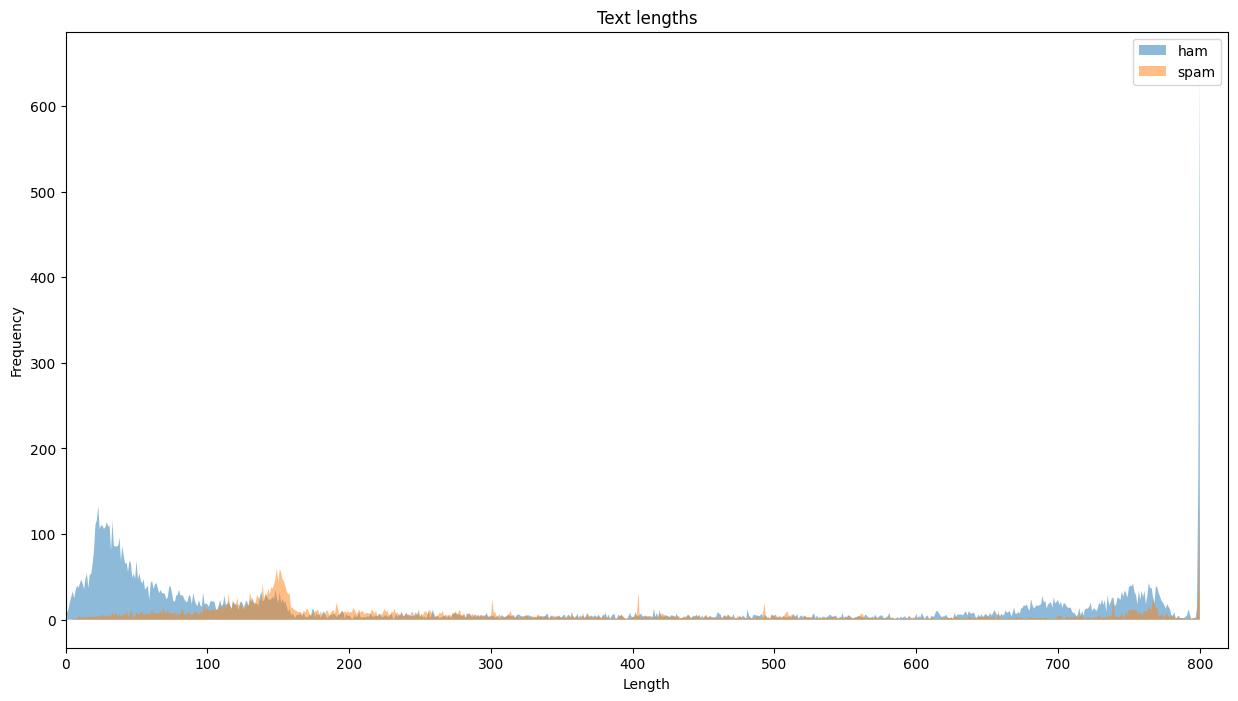

In [11]:
df = train_data.copy()
ham_df = df[df['text_type'] == 'ham']['text_length'].value_counts().sort_index()
spam_df = df[df['text_type'] == 'spam']['text_length'].value_counts().sort_index()

plt.figure(figsize=(15, 8))
plt.fill_between(ham_df.index, ham_df.values, alpha=0.5, label='ham')
plt.fill_between(spam_df.index, spam_df.values, alpha=0.5, label='spam')

plt.title('Text lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.xlim(0, 820)
plt.legend()
plt.show()


Видим, что спам сообщения в основном немаленькие, а большая часть не-спама наодится в промежутке длин до 200 символов.

In [ ]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords
stemmer = nltk.SnowballStemmer("english")

def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

def preprocess_data(text):
    text = clean_text(text)
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [ ]:
df['text_clean'] = df['text'].apply(preprocess_data)
df.head()

,text_type,text,text_length,text_clean
0,ham,make sure alex knows his birthday is over in f...,86,make sure alex know birthday fifteen minut far...
1,ham,a resume for john lavorato thanks vince i will...,520,resum john lavorato thank vinc get move right ...
2,spam,plzz visit my website moviesgodml to get all m...,126,plzz visit websit moviesgodml get movi free al...
3,spam,urgent your mobile number has been awarded wit...,139,urgent mobil number award £ prize guarante cal...
4,ham,overview of hr associates analyst project per ...,733,overview hr associ analyst project per david r...


In [ ]:
test_data["text_clean"] = test_data["text"].apply(preprocess_data)

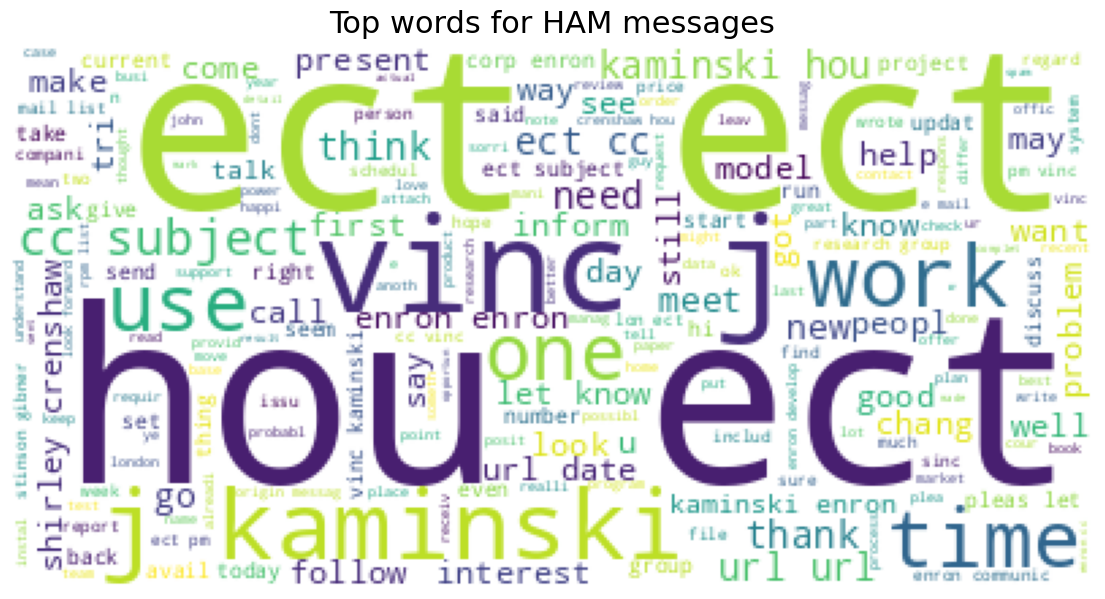

In [ ]:
wc = WordCloud(
    background_color='white',
    max_words=200,
)
wc.generate(' '.join(text for text in df.loc[df['text_type'] == 'ham', 'text_clean']))
plt.figure(figsize=(14,8))
plt.title('Top words for HAM messages',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

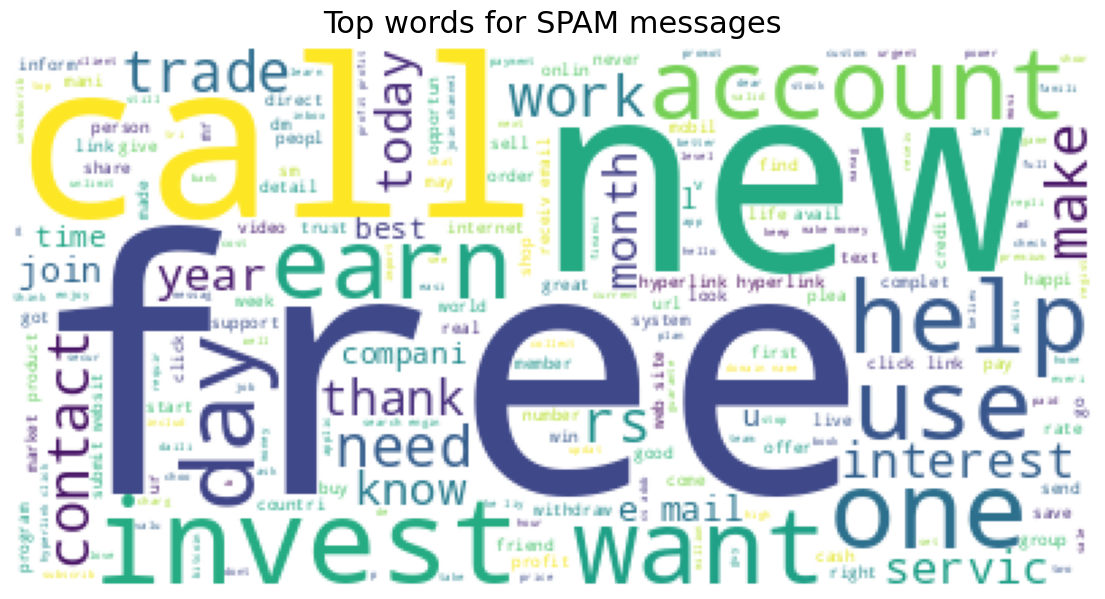

In [ ]:
wc = WordCloud(
    background_color='white',
    max_words=200,
)
wc.generate(' '.join(text for text in df.loc[df['text_type'] == 'spam', 'text_clean']))
plt.figure(figsize=(14,8))
plt.title('Top words for SPAM messages',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

Тут видим, что в основном спам сообщения связаны с каким то заработком или получением чего-либо бесплатно. Либо с какой-то помощью. А ham - особо не выделить, обычные слова.

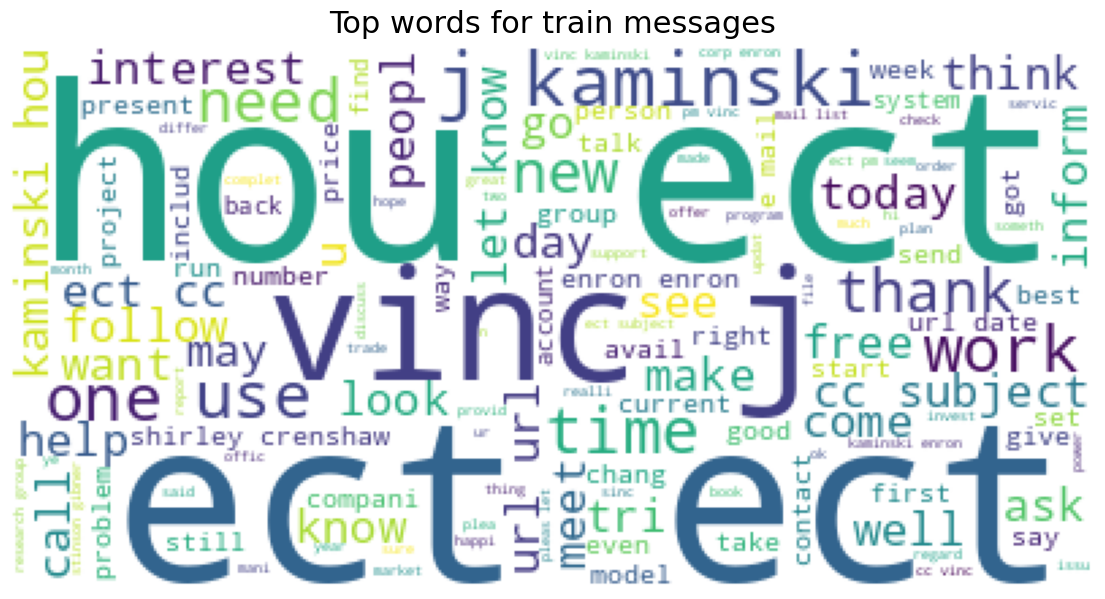

In [ ]:
wc = WordCloud(
    background_color='white',
    max_words=200,
)
wc.generate(' '.join(text for text in df['text_clean']))
plt.figure(figsize=(14,8))
plt.title('Top words for train messages',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

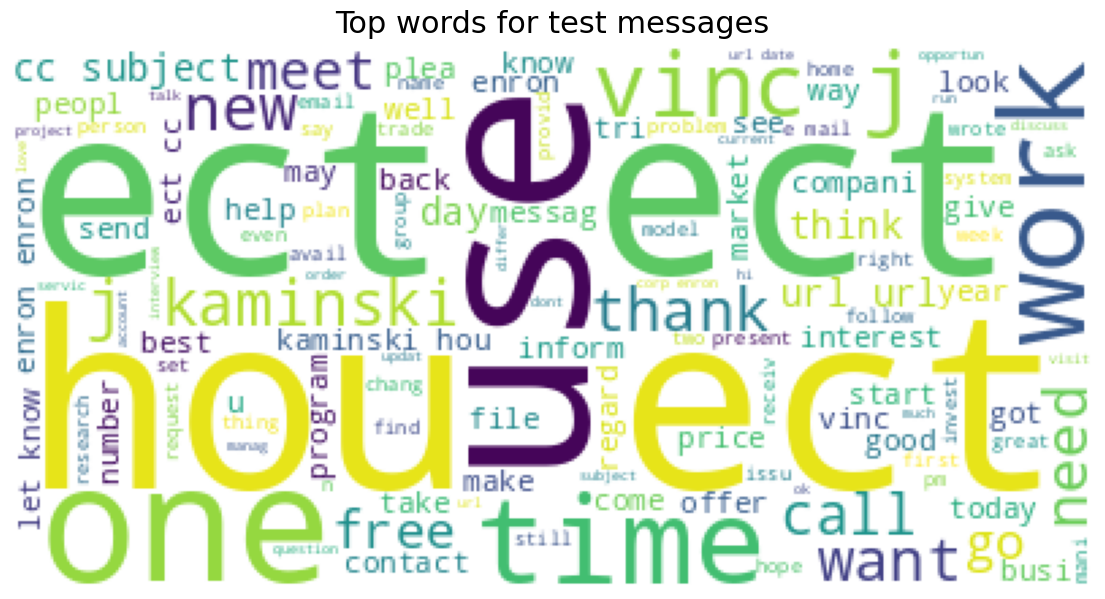

In [ ]:
wc = WordCloud(
    background_color='white',
    max_words=200,
)
wc.generate(' '.join(text for text in test_data['text_clean']))
plt.figure(figsize=(14,8))
plt.title('Top words for test messages',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

Видим, что облака совпадают практически полностью - следовательно, гипотеза о однообразности теста и трейна становится все более логичнее.

У нас много сообщений, и они довольно длинные => для подхода без нейронок использую TF-IDF

In [ ]:
def replace_spam(text_type):
    if text_type == "spam":
        return 1
    else:
        return 0

X_train = df["text_clean"]
y_train = df["text_type"]
y_train = y_train.apply(replace_spam)
X_test = test_data["text_clean"]

In [ ]:
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Сначала попробуем обычный логрег

In [ ]:
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train_tfidf, y_train, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train_train, y_train_train)
y_pred_proba = model.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, y_pred_proba)
print("ROC AUC Score:", roc_auc)


ROC AUC Score: 0.975786068608635


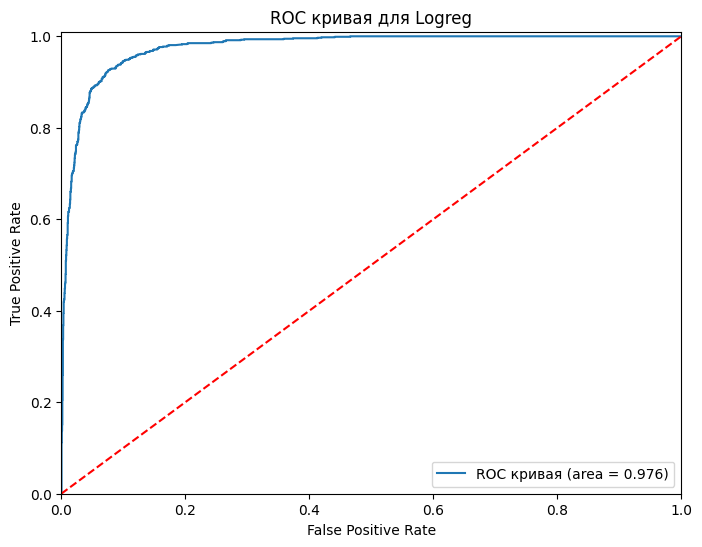

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая для Logreg')
plt.legend(loc="lower right")
plt.show()


Юзанем бустинг. Беру Catboost потому что я пешка яндекса, а еще потому что он работает лучше всего с коробки

In [ ]:
model = CatBoostClassifier(task_type="GPU", verbose = False)
model.fit(X_train_train, y_train_train)
y_pred_proba = model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.9728719641865599


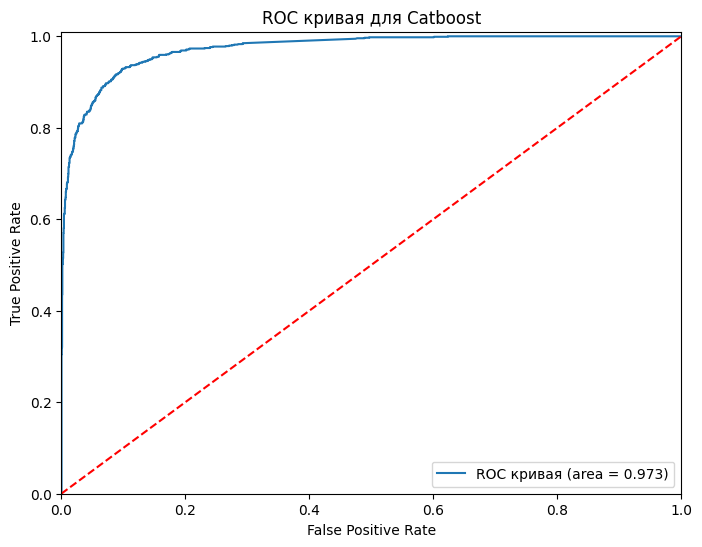

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая для Catboost')
plt.legend(loc="lower right")
plt.show()


Простая логистическая регрессия выбила лучший рокаук чем бустинг. Похоже обычная линейная модель тут лучше справляется чем нелинейный бустинг деревянный. Видимо взаимосвязи не такие уж и сложные.

Попробуем беггинг или бустинг на линейных моделях

In [ ]:
# gb_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)
# gb_clf.fit(X_train_train, y_train_train)
# gb_y_pred_proba = gb_clf.predict_proba(X_val)[:, 1]
# gb_roc_auc = roc_auc_score(y_val, gb_y_pred_proba)
# print("ROC AUC Score for Gradient Boosting:", gb_roc_auc)

bagging_clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=20, random_state=42)
bagging_clf.fit(X_train_train, y_train_train)
bagging_y_pred_proba = bagging_clf.predict_proba(X_val)[:, 1]
bagging_roc_auc = roc_auc_score(y_val, bagging_y_pred_proba)
print("ROC AUC Score for Bagging:", bagging_roc_auc)

ROC AUC Score for Bagging: 0.9747778364018829


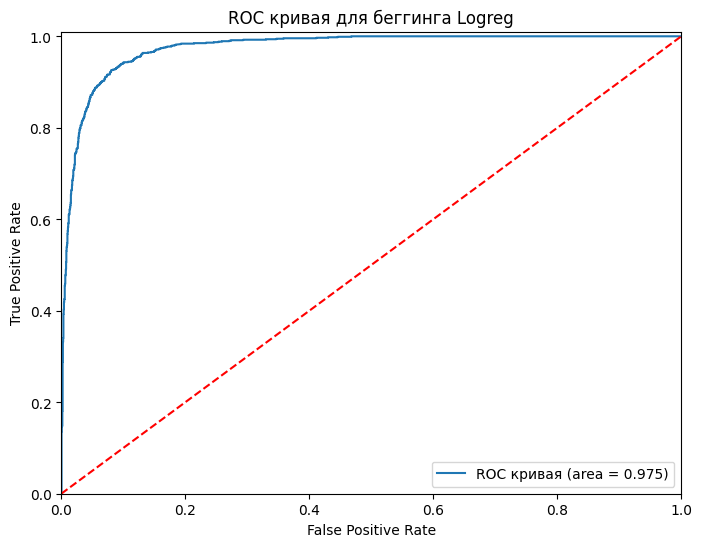

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, bagging_y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC кривая (area = %0.3f)' % bagging_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая для беггинга Logreg')
plt.legend(loc="lower right")
plt.show()


Простая моделька получилась все равно лучше, можно конечно потюнить, но следующий этап - BERT, на него у меня ставки большие, он точно лучше должен быть.

In [ ]:
device = torch.device("cuda")

In [ ]:
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# bert = BertModel.from_pretrained("bert-base-uncased")
# bert = BertModel.from_pretrained("prajjwal1/bert-small")
bert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
X_train = train_data["text"]
y_train = train_data["text_type"]
y_train = y_train.apply(replace_spam)
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
train_text = X_train_train
val_text = X_val
max_seq_len = 512
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train_train.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

In [ ]:
batch_size = 32
train_dataset = TensorDataset(train_seq, train_mask, train_y)
train_dataloader = DataLoader(train_dataset,  batch_size=batch_size, shuffle = True)

val_dataset = TensorDataset(val_seq, val_mask, val_y)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle = False)

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

for param in bert.pre_classifier.parameters():
    param.requires_grad = True
for param in bert.classifier.parameters():
    param.requires_grad = True


class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(512, 128) #768
        self.fc2 = nn.Linear(128, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, sent_id, mask):
        output = self.bert(sent_id, attention_mask=mask)
        # cls_hs = output["pooler_output"]
        # x = self.fc1(cls_hs)
        # x = self.relu(x)
        # x = self.dropout(x)
        # x = self.fc2(x)
        # x = self.sigmoid(x)
        return output

In [ ]:
model = BERT_Arch(bert)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr = 1e-3)
cross_entropy = nn.CrossEntropyLoss()

In [ ]:
def train():
    model.train()

    total_loss = 0

    total_preds=[]
    total_labels =[]

    for step, batch in tqdm(enumerate(train_dataloader)):


        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        model.zero_grad()

        preds = model(sent_id, mask)["logits"]
        loss = cross_entropy(preds, labels)
        # total_loss = total_loss + loss.item()
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # preds = preds.detach().cpu().numpy()
        preds = preds[:, 1].detach().cpu().numpy()
        # preds = np.argmax(preds, axis=1)

        # total_preds+=list(preds)
        # total_labels+=labels.tolist()
        labels = labels.detach().cpu().numpy()

        total_preds.append(preds)
        total_labels.append(labels)

    total_preds = np.concatenate(total_preds)
    total_labels = np.concatenate(total_labels)

    # avg_loss = total_loss / len(train_dataloader)

    # f1 = f1_score(total_labels, total_preds, average='weighted')
    roc_auc = roc_auc_score(total_labels, total_preds)
    return roc_auc

In [ ]:
def evaluate():

    print("\nEvaluating...")

    model.eval()
    total_preds = []
    total_labels = []
    total_loss = 0.0
    for step, batch in tqdm(enumerate(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)["logits"]
            # loss = cross_entropy(preds, labels)
            # total_loss = total_loss + loss.item()

        preds = preds[:, 1].detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

        total_preds.append(preds)
        total_labels.append(labels)

    # avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds)
    total_labels = np.concatenate(total_labels)

    roc_auc = roc_auc_score(total_labels, total_preds)
    return roc_auc


In [ ]:
epochs = 10
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    roc_train = train()
    roc_val = evaluate()

    print(f'train ROCAUC: {roc_train:.6f}')
    print(f'Validation ROCAUC: {roc_val:.6f}')


 Epoch 1 / 10


407it [04:14,  1.60it/s]



Evaluating...


102it [01:01,  1.65it/s]


train ROCAUC: 0.965240
Validation ROCAUC: 0.982496

 Epoch 2 / 10


407it [04:15,  1.60it/s]



Evaluating...


102it [01:01,  1.65it/s]


train ROCAUC: 0.980160
Validation ROCAUC: 0.984613

 Epoch 3 / 10


407it [04:15,  1.59it/s]



Evaluating...


102it [01:01,  1.65it/s]


train ROCAUC: 0.985515
Validation ROCAUC: 0.986439

 Epoch 4 / 10


407it [04:13,  1.60it/s]



Evaluating...


102it [01:01,  1.66it/s]


train ROCAUC: 0.987327
Validation ROCAUC: 0.987087

 Epoch 5 / 10


407it [04:12,  1.61it/s]



Evaluating...


102it [01:01,  1.67it/s]


train ROCAUC: 0.988677
Validation ROCAUC: 0.989306

 Epoch 6 / 10


407it [04:12,  1.61it/s]



Evaluating...


102it [01:01,  1.65it/s]


train ROCAUC: 0.989269
Validation ROCAUC: 0.988832

 Epoch 7 / 10


407it [04:13,  1.60it/s]



Evaluating...


102it [01:01,  1.66it/s]


train ROCAUC: 0.990356
Validation ROCAUC: 0.989441

 Epoch 8 / 10


407it [04:12,  1.61it/s]



Evaluating...


102it [01:01,  1.66it/s]


train ROCAUC: 0.991124
Validation ROCAUC: 0.990866

 Epoch 9 / 10


407it [04:13,  1.61it/s]



Evaluating...


102it [01:01,  1.67it/s]


train ROCAUC: 0.992156
Validation ROCAUC: 0.990505

 Epoch 10 / 10


407it [04:12,  1.61it/s]



Evaluating...


102it [01:01,  1.67it/s]

train ROCAUC: 0.992085
Validation ROCAUC: 0.990308


In [ ]:
!gdown --id "1QDx8lS55NO8nJxQdMcdd0G3noaf7qUPQ"

In [ ]:
model.load_state_dict(torch.load('bert_vk.pth'))

<All keys matched successfully>

102it [00:55,  1.85it/s]


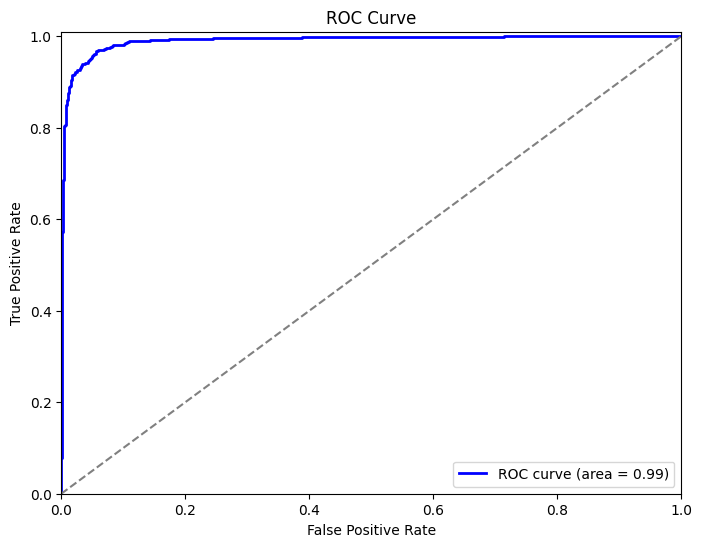

In [ ]:
model.eval()
total_preds = []
total_labels = []
total_loss = 0.0
for step, batch in tqdm(enumerate(val_dataloader)):
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch

    with torch.no_grad():
        preds = model(sent_id, mask)["logits"]
        preds = preds[:, 1].detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

        total_preds.append(preds)
        total_labels.append(labels)

total_preds = np.concatenate(total_preds)
total_labels = np.concatenate(total_labels)

fpr, tpr, thresholds = roc_curve(y_val, total_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'bert_vk.pth')

Нейронки пиреед


In [ ]:
X_test = test_data["text"]

In [ ]:
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [ ]:
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

In [ ]:
test_dataset = TensorDataset(test_seq, test_mask)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

In [ ]:
model.eval()
predictions = []
logits = []
probabilities = []

for batch in tqdm(test_dataloader):
    batch = [r.to(device) for r in batch]
    sent_id, mask = batch

    with torch.no_grad():
        outputs = model(sent_id, mask)["logits"]

    pred_labels = torch.argmax(outputs, dim=1).cpu().numpy()
    probs = torch.sigmoid(outputs).cpu().numpy()
    outputs = outputs.cpu().numpy()

    predictions.extend(pred_labels)
    logits.extend(outputs)
    probabilities.extend(probs)


100%|██████████| 128/128 [01:08<00:00,  1.87it/s]


In [ ]:
test_data["score"] = predictions
test_data["prob"] = probabilities
test_data["logits"] = logits
test_data

,text,text_length,text_clean,prob,score,logits
0,j jim whitehead ejw cse ucsc edu writes j you ...,683,j jim whitehead ejw cse ucsc edu write j open ...,"[0.9712395, 0.018613094]",0,"[3.519568, -3.9651015]"
1,original message from bitbitch magnesium net p...,576,origin messag bitbitch magnesium net peopl scr...,"[0.6739638, 0.27422687]",0,"[0.72616786, -0.97328174]"
2,java for managers vince durasoft who just taug...,688,java manag vinc durasoft taught java class gro...,"[0.9911698, 0.0051239454]",0,"[4.7207117, -5.2686934]"
3,there is a youtuber name saiman says,36,youtub name saiman say,"[0.8976202, 0.070795015]",0,"[2.1710577, -2.5745409]"
4,underpriced issue with high return on equity t...,753,underpr issu high return equiti oil gas adviso...,"[0.17864248, 0.8441067]",1,"[-1.525572, 1.6891067]"
...,...,...,...,...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,124,husband wifetum meri zindagi hoorwifeor kyatel...,"[0.93637466, 0.06430486]",0,"[2.689005, -2.6776545]"
4066,baylor enron case study cindy yes i shall co a...,396,baylor enron case studi cindi yes shall co aut...,"[0.9999895, 4.0634036e-06]",0,"[11.4681425, -12.413486]"
4067,boring as compared to tp,24,bore compar tp,"[0.97269183, 0.025737962]",0,"[3.572882, -3.6337132]"
4068,hellogorgeous hows u my fone was on charge lst...,138,hellogorg how fone charg lst nitw wen texd hop...,"[0.9959222, 0.003359411]",0,"[5.4981213, -5.6926246]"


In [ ]:
ans_df = test_data[["text", "score"]]
ans_df.to_csv("ans_encoded.csv")

In [ ]:
ans_df

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,0
1,original message from bitbitch magnesium net p...,0
2,java for managers vince durasoft who just taug...,0
3,there is a youtuber name saiman says,0
4,underpriced issue with high return on equity t...,1
...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,0
4066,baylor enron case study cindy yes i shall co a...,0
4067,boring as compared to tp,0
4068,hellogorgeous hows u my fone was on charge lst...,0


In [ ]:
def decode_spam(score):
    if score == 1:
        return "spam"
    else:
        return "ham"

ans_df_decoded = ans_df.copy()
ans_df_decoded["score"] = ans_df_decoded["score"].apply(decode_spam)
ans_df_decoded.to_csv("ans_decoded.csv")
ans_df_decoded.head(5)

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,ham
1,original message from bitbitch magnesium net p...,ham
2,java for managers vince durasoft who just taug...,ham
3,there is a youtuber name saiman says,ham
4,underpriced issue with high return on equity t...,spam


In [ ]:
ans_df_logits = test_data[["text", "logits"]]
ans_df_logits.rename(columns={'logits': 'score'}, inplace=True)
ans_df_logits.to_csv("ans_logits.csv")
ans_df_logits.head(5)

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,"[3.519568, -3.9651015]"
1,original message from bitbitch magnesium net p...,"[0.72616786, -0.97328174]"
2,java for managers vince durasoft who just taug...,"[4.7207117, -5.2686934]"
3,there is a youtuber name saiman says,"[2.1710577, -2.5745409]"
4,underpriced issue with high return on equity t...,"[-1.525572, 1.6891067]"


In [ ]:
ans_df_prob = test_data[["text", "prob"]]
ans_df_prob.rename(columns={'prob': 'score'}, inplace=True)
ans_df_prob.to_csv("ans_probs.csv")
ans_df_prob.head(5)

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,"[0.9712395, 0.018613094]"
1,original message from bitbitch magnesium net p...,"[0.6739638, 0.27422687]"
2,java for managers vince durasoft who just taug...,"[0.9911698, 0.0051239454]"
3,there is a youtuber name saiman says,"[0.8976202, 0.070795015]"
4,underpriced issue with high return on equity t...,"[0.17864248, 0.8441067]"


Почему BERT? Качество на валидации чуть лучше, но если в целом, я брал tfidf, а он не учитывает контекст, а просто собирает слова в мешок. BERT же - трансофрмер - и учитывает контекст с помощью attention слоев. Да и в целом, это новые технологии и очевидно, они будут лучше. Но ресурсозатратнее.

Не юзал word2vec и другие векторизаторы, учитывающие контекст, потому что трансформеры это улучшенная их версия.

`В директории будет несколько файлов`

`ans_decoded - это в столбце score - spam/ham`

`ans_encoded - 1/0`

`ans_scored - в столбце будут логиты `

`ans_probs - в столбце будет вероятностное представление логитов`

сделал так потому что не знаю, что требуется

In [ ]:
from google.colab import files
files.download('ans_probs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>